## Windows

The topic of windows in signal processing is quite extensive, underscoring its fundamental importance. We've in fact already encountered them without specifically stating it. In this notebook, we'll dive a bit into the relevance of windows and how they impact the frequency analysis of discrete-time signals. To dig a bit deeper into windows apart from this notebook, {cite:p}`Harris1978` is a classic reference.


In [1]:
%pip install ipympl
import numpy as np 
from scipy import signal
from matplotlib import pyplot as plt
from ipywidgets import * # interactive plots
import IPython
from IPython.display import Audio, Image
import io
from scipy.io import wavfile
from pyodide.http import pyfetch
%matplotlib ipympl


# We're going to be using our previous PSD function throughout this notebook
def psd(x,fs, psdtype):

    """
    This computes the double sided (Sxx) or single sided (Gxx) power spectral density (PSD)
    from a time-domain signal x. It does not include a correction for a window.
    
    Arguments:
        x       - time domain signal
        fs      - sampling frequency
        psdtype - 'Single' for Gxx, 'Double' for Sxx
        
    Returns:
        freq  - vector with the frequencies
        PSD   - Either Gxx or Sxx
        
    """
    if len(x) % 2 != 0: x = x[:-1] # This ensures that x has an even number of samples
    N = len(x)
    dt = 1/fs
    T = N*dt
    X = np.fft.fft(x)*dt    # Linear Spectrum (need to multiply by dt)
    Sxx = (1/T)*(abs(X)**2) # Double-Sided PSD
     # Frequencies
    
    if psdtype == 'Double':
        PSD = Sxx # Double-Sided PSD
        freq = np.fft.fftfreq(N, d=dt)
        
    elif psdtype =='Single':
        Gxx = Sxx[0:N//2 + 1].copy()
        Gxx[1:-1] = 2*Gxx[1:-1] # Single-Sided PSD
        PSD = Gxx
        freq = np.fft.rfftfreq(N, d=dt)
        
    else:
        print("Let psd = 'Single' or psd ='Double' ")
    
    return PSD,freq

### Effective bin filters

In the previous notebook, an important step in derivation of the discrete Fourier transform (DFT) was to sample the continuous-time Fourier transform (i.e., the continuous-time spectrum). For a discrete-time signal of $N$ samples, this is how we ended up with the concept for frequency bins, $k$, which corresponded to frequencies, $k \Delta f$, for $k = 0, 1, 2, \dots N-1$ and $\Delta f = f_s/N$ ($f_s$ being the sampling frequency). And for each of these discrete frequencies, the DFT yield a complex number from which we could compute a magnitude and phase. Subsequently, we used this to obtain a (one-sided) power spectral density (PSD), $G_{xx}$, for each of these frequencies. Now we can also think of $G_{xx}$ as being generated from filtering the continuous-time spectrum with an equivalent narrow filter (or effective bin filter) of width $\Delta f$. Ideally the process would occur as depicted in Fig.1, where we have some filter of width $\Delta f$ with an infinitely steep drop-off on either side. In such a case, the sampled $G_{xx}$ at frequency $k \Delta f$ would be representative of the power of the signal from ($k \Delta f -  \Delta f/2$) to ($k \Delta f +  \Delta f/2$).

<br>

<div>
<center> <img src="eff_bin_filt.png" width="550"/> <center/>
    <p style="text-align:center">Fig. 1 - Ideal effective bin filter </p>
</div>

<br>

Unfortunately, things are not this nice in practice. In fact, although for continuous-time signals, the discrete-time version represents the exact continuous-time value at some specific time, $t = n T_{s}$ ($T_s = 1/f_s$, the sampling period and $n$ is an index), the points in a sampled spectrum are not samples of the continuous-time spectrum. Rather they are estimates of the true continuous-time spectrum and this is precisely due to the the shape of the effective bin filter in practice (it does not have infinitely steep drop-off).  So what do bin filters actually look like?

### Rectangular/Boxcar window

Well this depends on the type of **window** function we apply to the signal. A window is simply some mathematical function defined over a particular interval and then set to zero outside of that interval. Windows also tend to be symmetrical over the interval for which its mathematical function is defined. So far instance, a window of $N$ samples that is symmetric around zero will be defined by a mathematical function from samples $-N/2 + 1$ to $N/2$ and zero elsewhere. We have in fact been using windows since the previous chapter when extracting time frames from a longer singal. In that case, the window was simply $w[n] = 1$ (for $n = 0, 1, 2, \dots N-1$), and is known as a **rectangular** or **boxcar** window and we were implicitly multiplying a long time series by this window to extract a segment of $N$ samples. Before moving on to other types of windows, let's firstly focus a bit more on this rectangular window, observe the nature its bin filter, and the impact it has on the spectrum of the signal. Although we'll use a discrete version of it in practice, we can get a more theoretical understanding by considering a continuous-time version. 

The left-hand side of Fig. 1 depicts a continuous-time rectangular window that is symmetrical around zero (this is simply for mathematical convenience in the following derivations) with a width of $T$ seconds and an amplitude of $1/T$ (note that this is a separate time variable $T$, not the sampling period, $T_s$!). An amplitude of $1/T$  is used as a opposed to $1$ to avoid a scaling in the frequency domain. Let's take the continuous-time Fourier transform of the rectangular window, and denote it as $W_{R}(f)$:

$\begin{align}
W_{R}(f) &= \int\limits_{-T/2}^{T/2} \frac{1}{T} e^{-j2\pi ft} = \frac{\sin(\pi f T)}{\pi f T} = \text{sinc}(\pi f T) = \text{sinc}\left(\frac{\pi f}{\Delta f}\right)
\end{align}$

where the sinc function (proncounced "sink") is defined as
$\begin{equation}
\text{sinc}(x) = \begin{cases} 1 \hspace{1.6cm} x = 0 \\
                        \sin(x)/x \hspace{0.5cm} x \neq 0\end{cases}
\end{equation}$

We have also used the relationship for a discrete-time signal where $T = N T_{s} = N/fs = 1/\Delta f$. This spectrum is sketched in the right-hand side of Fig. 2. You should notice that the spectrum cuts the x-axis at several points, i.e., $W_{R}(f) = 0$ for several values of $f$. These frequencies, $f$, occur when $\text{sinc}\left(\pi f/\Delta f\right) = 0$, and hence when $\sin\left(\pi f/\Delta f\right) = 0$. This occurs when the argument of the sin function is equal to integer multiples of $\pi$:

$\begin{align}
\left(\frac{\pi f}{\Delta f}\right)  &= \pm k \pi  \hspace{0.5cm} \text{for} \hspace{0.1cm} k = 0, 1, 2, \dots, \infty \\
    f &= k \Delta f
\end{align}$

<br>

<div>
<center> <img src="box_sinc.png" width="550"/> <center/>
    <p style="text-align:center">Fig. 2 - (Left) Time-domain rectangular window, (Right) Fourier transform (sinc function) of rectangular window. </p>
</div>

<br>

When we multiply the time-series by a rectangular window in the time-domain, this corresponds to a convolution in the frequency domain between the continuous-time spectrum of the time-series signal, which we denote as $X(f)$, and the continuous-time spectrum of the rectangular window, $W_{R}(f)$. We'll cover convolution in a later notebook, so for now we're only interested in the result (not how we got there). At some frequency corresponding to $f = k\Delta f$, this convolution is mathematically given as

$\begin{align}
X[k] &= \int \limits_{-f_{s}/2} ^{f_s/2} X(f) W_{R}(f - k\Delta f) df \\
     &= \int \limits_{-f_{s}/2} ^{f_s/2} X(f)  \text{sinc}\left(\frac{\pi (f - k\Delta f)}{\Delta f}\right) df 
\end{align}$

The term, $W_{R}(f - k\Delta f)$ is simply the same sinc function we derived before, except that for different values of $k$, it is shifted such that the maximum of the sinc function will occur at frequencies, $f = k\Delta f$. This means that it is precisely this sinc function which is acting as our effective bin filter (not the ideal filter with an infinitely steep roll-off as we started thinking about). Therefore what this equation is telling us is that the sampling of the continuous-time frequency spectrum occurs as follows: for each frequency bin, $k$, (i) the sinc function is repositioned so its maximum (of 1) occurs at that bin, (ii) the sinc function is then multiplied with the continuous-time spectrum, $X(f)$, and (iii) finally the product is integrated (summed) from frequencies $-f_s/2$ to $f_s/2$ (equivalently this could be from $0$ to $f_s$, but that's just a matter of how we define the symmetry of the Fourier transform, in this case it was mathematically more convenient to make that around zero).

This was all admittedly quite a bit to digest, so let's try and gain some more intuition through a few interactive plots. There are two plots we're showing below across an arbitrary frequency range:

1. On the left is the function $W_{R}(f - k\Delta f) = \text{sinc}\left(\pi (f - k\Delta f)/\Delta f\right)$ with two sliders - $k$ and $\Delta f$ to control the behaviour of the function. The grey vertical lines correspond to the frequency bins at $k = \dots, -2, 1, 0, 1, 2, \dots$, corresponding to the frequencies $k \Delta f$. Note that irrespective of how we change $k$ and $\Delta f$, these vertical lines (apart from $k=0$) line up exactly with the zero-crossings of the sinc function (which is what we derived above).

2. The plot on the right is illustrative of what the actual sampling process through the convolution integral above can look like. This is for a specific instance when $\Delta f = 10$ Hz, and shows two of the sinc functions ($W_{R}(f - k\Delta f)$) - one at $k=2$ and the other at $k=3$. The solid black line is representative of the continuous-time spectrum of a single sinusoidal component ($X(f)$) with frequency $f_{\text{sine}}$, which is included as a slider. For whatever value of $f_sine$ you choose, then we can imagine what the sampled spectrum will look like at $X[2]$ for instance - a multiplication of the sinc function (($W_{R}(f - 2 \Delta f)$)) and the solid black line, followed by an integration (sum) from $-f_s/2$ to $f_s/2$. The same process then happens at $X[3]$, $X[4]$, etc. until we have all values for $X[k]$.

The first two parameters control the sinc function on the left. The third parameter controls the frequency of the sine wave on the right.


interactive(children=(FloatSlider(value=5.0, description='df', max=20.0, min=5.0), IntSlider(value=0, descript…

<function __main__.interactive_sinc(df=5, k=0, f_sine=20)>

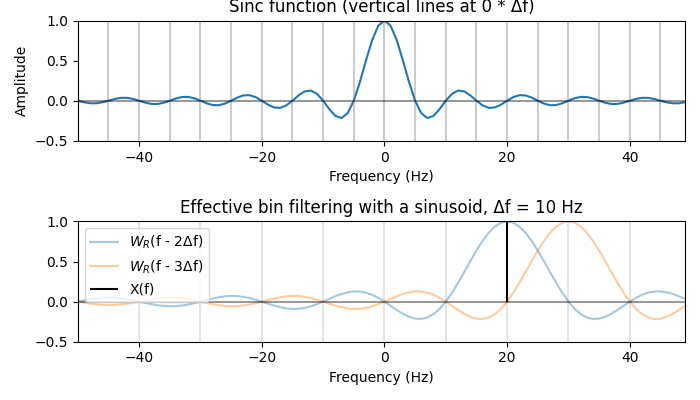

In [3]:
# sinc function 
f = np.arange(-50, 50, 1) # frequency array

fig, ax = plt.subplots(2,1, figsize=(7,4))

line, = ax[0].plot([], [])
vlines = ax[0].vlines([], 0, 1, color='gray', alpha=0.4)
ax[0].axhline(0, color='black', alpha=0.4)
ax[0].set_xlabel('Frequency (Hz)')
ax[0].set_ylabel('Amplitude')
ax[0].set_xlim([np.min(f), np.max(f)])
ax[0].set_ylim([-0.5,1])

line2, = ax[1].plot([], [],'-', alpha=0.4, label='$W_{R}$(f - 2Δf)')
line3, = ax[1].plot([], [],'-', alpha=0.4, label='$W_{R}$(f - 3Δf)')
vlines2 = ax[1].vlines([], 0, 1, color='gray', alpha=0.2)
kdf_fixed = np.arange(-10,10,1) * 10
segments_fixed = [((xx, -0.5), (xx, 1)) for xx in kdf_fixed]
vlines2.set_segments(segments_fixed) 
vline_sine = ax[1].vlines([], 0, 1, color='black', label='X(f)')
ax[1].axhline(0, color='black', alpha=0.4)
ax[1].set_xlabel('Frequency (Hz)')
#ax[1].set_ylabel('Amplitude')
ax[1].set_title('Effective bin filtering with a sinusoid, Δf = 10 Hz')
ax[1].set_xlim([np.min(f), np.max(f)])
ax[1].set_ylim([-0.5,1])
ax[1].legend(loc='upper left')

# Interactive plot to show the RMS computation with different sine waves
def interactive_sinc(df = 5, k=0, f_sine=20):
	
    fig.canvas.draw_idle()

    # left plot
    x = np.sinc((f - k*df)/df)
    # vertical lines corresponding to k * delta_f
    kdf = np.arange(-10,10,1) * df
    segments = [((xx, -0.5), (xx, 1)) for xx in kdf]
    vlines.set_segments(segments)   # update line positions
    # Update time-domain plot
    line.set_data(f, x)
    ax[0].set_title('Sinc function (vertical lines at '+str(k)+' * Δf)')


    # right plot - a specific instance of df
    x2 = np.sinc((f - 2*10)/10)
    x3 = np.sinc((f - 3*10)/10)
    line2.set_data(f, x2)
    line3.set_data(f, x3)
    vline_sine.set_segments([((f_sine, 0), (f_sine, 1))])
     

plt.tight_layout()
print("The first two parameters control the sinc function on the left. The third parameter controls the frequency of the sine wave on the right.")
interact(interactive_sinc, df=(5, 20, 0.1), k=(-5,5,1), f_sine=(15,35,0.1))

### Spectral Leakage

Now that we've gotten some insight into how the sampling of the continuous-time spectrum is actually being sampled, we can highlight an important problem. When the frequency of the sinusoid (the black line) was a multiple of $\Delta f$, at $20$ Hz for example, this coincided with the maximum of the sinc function at that frequency bin (an amplitude of 1). Also recall that the zero crossings of the sinc function occurs at all other frequencies, $k \Delta f$ ($k \neq 2$ in this example). Hence in the the convolution integral previously discussed, multiplying the sinc function and the continuous-time spectrum, and integrating across frequency yields exactly that sinusoidal component at $20$ Hz, which is what we would expect.

If the sinusoid was, however, at a frequency that is not a multiple of $\Delta f$, at $15$ Hz for example, it now lies between two discrete frequency bins. Hence the continuous-time spectrum no longer coincides with the maximum of any of the sinc functions at any of the discrete frequencies $k \Delta f$. The result is that for each frequency, $k \Delta f$, when we multiply the sinc function by the continuous-time spectrum and integrate across frequency, there will be some non-zero contribution particularly in the frequency bins nearby the $15$ Hz component. In other words, as the frequency bin spacing is such that it cannot exactly resolve the $15$ Hz component, the true continuous-time spectrum "leaks" into other frequency bins. In this case, we can expect some information to be present in the $5$ Hz, $10$ Hz, $20$ Hz, and $25$ Hz frequency bins. This is what we refer to as **spectral leakage**. It's problematic in that it creates uncertainty as to what are the true frequencies embedded in our audio signal and it's also highlights why the choice of $\Delta f$ is so critical.

Let's actually see the impact of this on the PSD of a sine wave. In the following plot, we fix $\Delta f = 5$ Hz, and include a slider to change the frequency of the sine wave to observe the PSD, $G_{xx}$. Pay attention to the frequencies of the sine waves and observe when spectral leakage occurs. We'll also compute the RMS of the sine wave directly from $G_{xx}$ as we previously did. As you will observe, the estimates can be quite inaccurate when spectral leakage occurs and we have to be "lucky" to have frequencies that are multiples of $\Delta f$.

Adjust the frequency the sine wave using the slider below


interactive(children=(IntSlider(value=100, description='f1', max=200, min=50), Output()), _dom_classes=('widge…

<function __main__.interactive_psd(f1=100)>

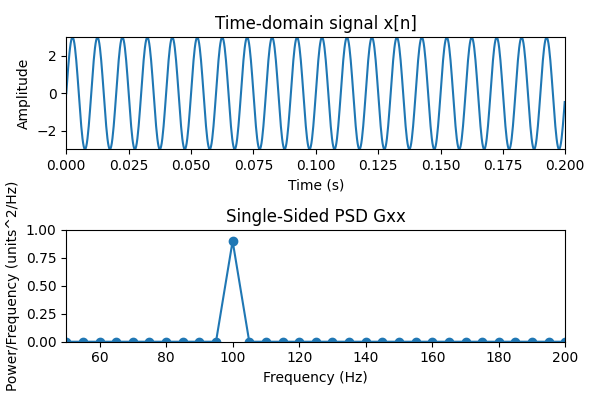

In [275]:
fs = 4000   # let's assume some sampling frequency in Hz
T = 0.2     # duration of the signal in seconds
t = np.arange(0, T, 1/fs) # time array


fig, ax = plt.subplots(2,1, figsize=(6,4))
    
timeplot, = ax[0].plot([], [])
ax[0].set_title('Time-domain signal x[n]')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Amplitude')
ax[0].set_xlim([0, T])
ax[0].set_ylim([-3,3])

psdplot, = ax[1].plot([], [],'-o')
#psdplot_max, = ax[1].plot([], [],'-x')
ax[1].set_title('Single-Sided PSD Gxx')
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Power/Frequency (units^2/Hz)')
ax[1].set_xlim([50,200])
ax[1].set_ylim([0, 1])


# Interactive plot to show the RMS computation with different sine waves
def interactive_psd(f1=100):
	
    fig.canvas.draw_idle()
    
    # Create sine wave
    x = 3*np.sin(2*np.pi*f1*t) 

    # Compute the single-sided PSD
    Gxx, fG = psd(x, fs, 'Single')
    df = fG[1] - fG[0]  # equivalent to fs/N, but that was already computed in the function
    print('Delta-f =', df, ' Hz')
    Gxx_max = np.max(Gxx) # maximum value of Gxx
    freq_Gxx_max = fG[np.argmax(Gxx)] # frequency at which max occurs

    # Update time-domain plot
    timeplot.set_data(t, x)
    
    # Update PSD plot
    psdplot.set_data(fG, Gxx)
    
    print("RMS of x[n] using the time-domain signal, sqrt(1/N*sum(x[n]^2)) =", np.sqrt(np.mean(x**2)))
    print("RMS of x[n] using the PSD sqrt(Gxx_max*df) =", np.sqrt(Gxx_max*df))
    
    
plt.tight_layout()
    
    
print("Adjust the frequency the sine wave using the slider below")
interact(interactive_psd, f1=(50, 200, 1))


### The need for windows

In our discussion of the [periodicity and symmetry of the DFT](https://randyaliased.github.io/acspjbook/main/fundamental/07_DFT.html#periodicity-and-symmetry), one interpretation we made was that the finite time-series of $N$ samples is repeated over and over. If we think of a rectangular-windowed sine wave that is being repeated, we can expect that depending on the length of the windowed-signal, there will be instances where there are discontinuities (instantaneous jumps in amplitude) between repetitions of the series as shown in Fig. 3. These discontinuities occur when the frequency of the sine wave is not an integer multiple of $\Delta f$ and hence account for the spectral leakage. 

<br>

<div>
<center> <img src="window_discont.png" width="350" height="200"/> <center/>
    <p style="text-align:center">Fig. 3 - Potential discontinuity when using rectangular windows </p>
</div>

<br>

Hence the stratgey to minimize spectral leakage involves the reduction of such discontinuities, and has resulted in the development of several types of symmetrical windows which have tapered ends at the beginning and the end of the time-series. The tapered ends of these windows restore the periodicity in the signal and hence reduce spectral leakage, but they also impact the signal in the frequency domain. There is a tradeoff that has to be made depending on the application, and is why there are so many [many different types of windows](https://en.wikipedia.org/wiki/Window_function) to choose from in practice. In audio, a common window you will encounter is the [Hanning window](https://en.wikipedia.org/wiki/Hann_function). But let's take a look at a few different types of windows and observe their impact. There are lots of [windows to choose from in Python](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.windows.get_window.html#scipy.signal.windows.get_window) so feel free to explore them in the following code snippet. 

There's a subplot of 4 figures below:
1. In the first row, we plot the time-domain signal of the window in the left column, and its *normalized* DFT magnitude in the right column. We normalize the DFT magnitude and centre it around 0 Hz so that we can observe how the shape of the effective bin filter of the window changes.Remember we've already looked at the rectangular/boxcar one before - you will see that it looks a little different here, but that's only because we are plotting the points at $0$ Hz (where the sinc function is 1), and other multiples of $\Delta f$ (where the sinc function is 0).

2. In the second row, we multiply this window with a sine wave. In the left column is the time-domain signal - note the tapered ends from the application of various windows. In the right column is the corresponding PSD of the signal (not normalized) where we can see the impact of the window on the frequency domain of the signal.

There are also two sliders we can control (i) one slider for viewing different windows, and (ii) another slider to change the frequency of sine. For a particular window, slide through different frequencies of the sine wave to observe what happens. Important questions to ask yourself:
- Are we still able to estimate the RMS of the sine wave with different frequencies? 
- Do we preserve Parseval's relationship (energy equivalence) when using windows? Why or why not? 

Adjust the frequency and amplitude of the sine wave using the sliders below


interactive(children=(FloatSlider(value=100.0, description='f1', max=200.0, min=50.0), IntSlider(value=1, desc…

<function __main__.interactive_psd(f1=100, win_type=1)>

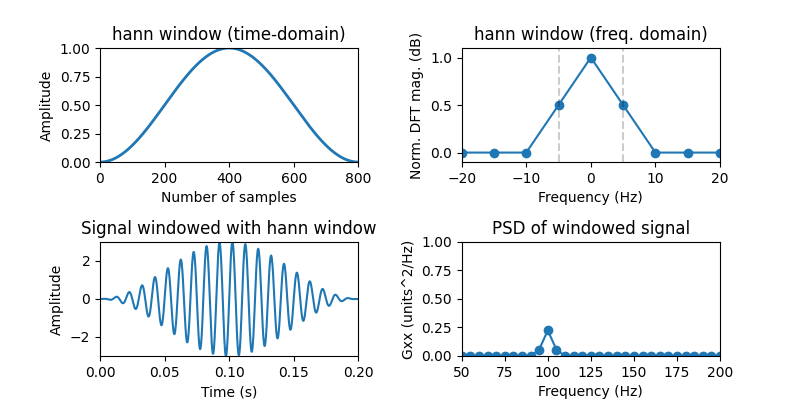

In [9]:
fs = 4000   # let's assume some sampling frequency in Hz
T = 0.2 # duration of the signal in seconds
t = np.arange(0, T, 1/fs) # time array
n = np.arange(0, len(t),1) # sample index
N = len(t) # number of samples
freq_win = np.fft.fftfreq(N, d=1/fs) # frequency array for the window

# We'll use the signal.get_window function to obtain the windows.
# Add more to this list as you wish from the available ones: 
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.windows.get_window.html#scipy.signal.windows.get_window

window_types = ['boxcar', 'hann', 'blackman', 'hamming', 'flattop'] 


# PLOTS
fig, ax = plt.subplots(2,2, figsize=(8,4))
plt.subplots_adjust(wspace=0.4, hspace=0.7)
winplot, = ax[0,0].plot([], [], linewidth=2)
ax[0,0].set_xlabel('Number of samples')
ax[0,0].set_ylabel('Amplitude')
ax[0,0].set_xlim([0, N])
ax[0,0].set_ylim([0,1])

dftmag, = ax[0,1].plot([], [],'-o')
ax[0,1].axvline(fs/N, color='k', linestyle='--',alpha=0.2)
ax[0,1].axvline(-fs/N, color='k', linestyle='--',alpha=0.2)
ax[0,1].set_xlabel('Frequency (Hz)')
ax[0,1].set_ylabel('Norm. DFT mag. (dB)')
ax[0,1].set_xlim([-20,20])
ax[0,1].set_ylim([-0.1, 1.1])

timeplot, = ax[1,0].plot([], [])
ax[1,0].set_xlabel('Time (s)')
ax[1,0].set_ylabel('Amplitude')
ax[1,0].set_xlim([0, T])
ax[1,0].set_ylim([-3,3])

psdplot, = ax[1,1].plot([], [],'-o')
ax[1,1].set_title('PSD of windowed signal')
ax[1,1].set_xlabel('Frequency (Hz)')
ax[1,1].set_ylabel('Gxx (units^2/Hz)')
ax[1,1].set_xlim([50,200])
ax[1,1].set_ylim([0, 1])


# Interactive plot to show the RMS computation with different sine waves
def interactive_psd(f1=100, win_type=1):
	
    fig.canvas.draw_idle()
    
    win = signal.get_window(window_types[win_type], N) # get window

    # Plots of windows and their normalized DFT magnitudes
    # Update time-domain plot
    winplot.set_data(n, win)
    ax[0,0].set_title(window_types[win_type]+' window (time-domain)')

    # DFT
    X = np.fft.fft(win)    
    #X_mag = np.abs(X)*(1/fs)
    X_mag = np.abs(X)/np.max(np.abs(X)) # normalize
    sort_ind = np.argsort(freq_win)
    X_mag = X_mag[sort_ind]
    freq_win_sorted = freq_win[sort_ind]  


    # Update DFT magnitude plot
    dftmag.set_data(freq_win_sorted, (X_mag))
    ax[0,1].set_title(window_types[win_type]+' window (freq. domain)')


    # Plots of windowed signals
    # Create sine wave
    x = 3*np.sin(2*np.pi*f1*t)
    
    x_win = x * win

    # Compute the single-sided PSD
    Gxx, fG = psd(x_win, fs, 'Single')
    df = fG[1] - fG[0]  # equivalent to fs/N, but that was already computed in the function
    Gxx_max = np.max(Gxx) # maximum value of Gxx
    # freq_Gxx_max = fG[np.argmax(Gxx)] # frequency at which max occurs

    # Update time-domain plot
    timeplot.set_data(t, x_win)
    ax[1,0].set_title('Signal windowed with ' + window_types[win_type]+' window')
    # Update PSD plot
    psdplot.set_data(fG, Gxx)
    
    
    # # Checking the energy equivalence
    print("Mean-square of x[n], 1/N*sum(x[n]^2) =", np.mean(x**2))
    print("Gxx * df =", np.sum(Gxx)* df)
    # # RMS values
    print("RMS of x[n] using the time-domain signal, sqrt(1/N*sum(x[n]^2)) =", np.sqrt(np.mean(x**2)))
    print("RMS of x[n] using the PSD sqrt(Gxx_max*df) =", np.sqrt(Gxx_max*df))
    
    
#plt.tight_layout()
    
print("Adjust the frequency and amplitude of the sine wave using the sliders below")
interact(interactive_psd, f1=(50, 200, 0.1), win_type=(0, len(window_types)-1, 1))


### The need for a PSD correction factor

There are a few takeways from the previous plots:
- The windows with tapered ends seem to help with spectral leakage. With these windows (in comparison to the rectangular/boxcar), there seems to be alot more consistency in how the sine wave is spread across different frequency bins regardless of its fundamental frequency.
- We are still unable to estimate the correct RMS of the sinusoid from the PSD, things seem to be a bit worse that using the rectangular window (albeit consistently worse).
- We are no longer satisfying the energy equivalence between the time and frequency domains that we established when deriving the PSD formulations, i.e., $1/N \sum_{n=0}^{N-1} x[n]^{2} \neq \sum_{k=0}^{N/2} G_{xx}[k] df$ (where $x[n]$ is the original signal without the window applied). This makes sense though because when the window is multiplied by $x[n]$, the tapering of the window removes some of the signal (as we saw in the time-domain plot).\

This final point is quite problematic because it completely breaks Parseval's theorem and our PSD is no longer representative of the mean square of the original time-domain signal. This motivates the need for a **PSD ccorrection factor** when using windowed time-domain signals. Let's derive this correction factor.

Let's denote the windowed time-domain signal as $y[n]$ for $n=0,1,2, \dots, N-1$ as

$\begin{equation}
y[n] = w[n] x[n]
\end{equation}$

where $w[n]$ is the window and $x[n]$ is the original time-domain signal. From the energy equivalence relationship of the PSD, we know that

$\begin{align}
\sum\limits_{k=0}^{N/2}G_{yy}[k] \Delta f &= \frac{1}{N} \sum\limits_{n=0}^{N-1} y[n]^{2} \\
                                          &= \frac{1}{N} \sum\limits_{n=0}^{N-1} w[n]^{2} x[n]^{2}
\end{align}$

where $G_{yy}[k]$ for $k=0, 1, 2, \dots N/2$ is the single-sided PSD of $y[n]$. But we would like to obtain a correction factor, $A_{w}$, such that we establish the following energy equivalence with $x[n]$:

$\begin{align}
A_{w} \sum\limits_{k=0}^{N/2}G_{yy}[k] \Delta f &= \frac{1}{N} \sum\limits_{n=0}^{N-1} x[n]^{2} 
\end{align}$

And hence the correction factor $A_{w}$ is

$\begin{align}
A_{w}  &= \frac{1}{\sum\limits_{k=0}^{N/2}G_{yy}[k] \Delta f} \frac{1}{N} \sum\limits_{n=0}^{N-1} x[n]^{2} = \frac{\sum\limits_{n=0}^{N-1} x[n]^{2}}{\sum\limits_{n=0}^{N-1} w[n]^{2} x[n]^{2}}
\end{align}$

In the case where $x[n]$ is a stationary signal, i.e., $x[n]$ is a constant, the correction factor then reduces to

$\begin{align}
A_{w}  &= \frac{N}{\sum\limits_{n=0}^{N-1} w[n]^{2}}
\end{align}$

Although the first expression for $A_{w}$ can accomodate for time-varying signals, much of the acoustic signal processing community nevertheless uses the simpler PSD correction factor assuming $x[n]$ is a constant. Although this can give erroneous results for certain types of signals, it is nevertheless widely employed (it is something to think about when you are using it in practice). At any rate, let's define a new PSD function with this correction factor and see if this helps! Have a look at the plots below and see if the energy equivalence now holds regardless of the frequency of the sine wave.

Adjust the frequency and amplitude of the sine wave using the sliders below


<>:31: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:31: SyntaxWarning: "is" with a literal. Did you mean "=="?
/var/folders/ng/90xk1wjn2014rw8nb9bql2200000gp/T/ipykernel_16545/2269819968.py:31: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if win is 'None':


interactive(children=(FloatSlider(value=100.0, description='f1', max=200.0, min=50.0), IntSlider(value=1, desc…

<function __main__.interactive_psd(f1=100, win_type=1)>

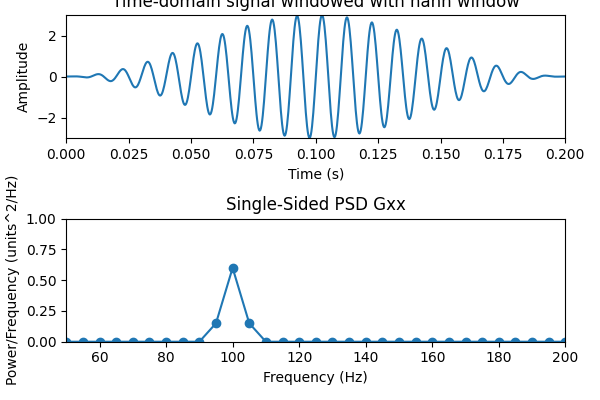

In [10]:
fs = 4000   # let's assume some sampling frequency in Hz
T = 0.2 # duration of the signal in seconds
t = np.arange(0, T, 1/fs) # time array
window_types = ['boxcar', 'hann', 'blackman', 'hamming', 'flattop'] # more in scipy.signal.get_window

# This is a function to compute the PSD
def win_psd(x,fs, win='None', psdtype='Single'):

    """
    This computes the double sided (Sxx) or single sided (Gxx) power spectral density (PSD)
    from a windowed time-domain signal x. It includes a correction for a window.
    
    Arguments:
        x       - time domain signal
        fs      - sampling frequency
        win     - window applied to the signal (This is the window signal of the same length as x)
        psdtype - 'Single' for Gxx, 'Double' for Sxx
        
    Returns:
        freq  - vector with the frequencies
        PSD   - Either Gxx or Sxx
        
    """
    if len(x) % 2 != 0: x = x[:-1] # This ensures that x has an even number of samples
    N = len(x)
    dt = 1/fs
    T = N*dt
    t = np.arange(0, T, 1/fs)

    # Defaults window
    if win is 'None':
        win = signal.get_window('boxcar', N) # default to rectangular window if none provided

    x_win = x * win # apply window to the signal
    Aw = N/(np.sum(win**2)) # window correction factor

    X = np.fft.fft(x_win)*dt    # Linear Spectrum (need to multiply by dt)
    Sxx = (1/T)*(abs(X)**2) # Double-Sided PSD

    if psdtype == 'Double':
        PSD = Aw*Sxx # Double-Sided PSD with correction
        freq = np.fft.fftfreq(N, d=dt)
        
    elif psdtype =='Single':
        Gxx = Sxx[0:N//2 + 1].copy()
        Gxx[1:-1] = 2*Gxx[1:-1] # Single-Sided PSD
        PSD = Aw*Gxx # Single-Sided PSD with correction
        freq = np.fft.rfftfreq(N, d=dt)
        
    else:
        print("Let psd = 'Single' or psd ='Double' ")
    
    return PSD,freq, x_win, t # also return the windowed time-domain signal

fig, ax = plt.subplots(2,1, figsize=(6,4))
    
timeplot, = ax[0].plot([], [])
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Amplitude')
ax[0].set_xlim([0, T])
ax[0].set_ylim([-3,3])

psdplot, = ax[1].plot([], [],'-o')
#psdplot_max, = ax[1].plot([], [],'-x')
ax[1].set_title('Single-Sided PSD Gxx')
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Power/Frequency (units^2/Hz)')
ax[1].set_xlim([50,200])
ax[1].set_ylim([0, 1])


# Interactive plot to show the RMS computation with different sine waves
def interactive_psd(f1=100, win_type=1):
	
    fig.canvas.draw_idle()
    
    # Create sine wave
    x = 3*np.sin(2*np.pi*f1*t)
    win = signal.get_window(window_types[win_type], len(x)) # get the window

    # Compute the single-sided PSD (this also does the windowing of the time-domain signal)
    Gxx, fG, x_win, time = win_psd(x, fs, win, 'Single')
    df = fG[1] - fG[0]  # equivalent to fs/N, but that was already computed in the function
    print(df)
    Gxx_max = np.max(Gxx) # maximum value of Gxx
    freq_Gxx_max = fG[np.argmax(Gxx)] # frequency at which max occurs

    # Update time-domain plot
    timeplot.set_data(time, x_win)
    ax[0].set_title('Time-domain signal windowed with ' + window_types[win_type]+' window')
    # Update PSD plot
    psdplot.set_data(fG, Gxx)
    
    # play audio
    #IPython.display.display(Audio(x.T, rate=fs, autoplay=False))
    
    # # Checking the energy equivalence
    # print("Checking the energy equivalence:")
    print("Mean-square of x[n], 1/N*sum(x[n]^2) =", np.mean(x**2))
    print("Gxx * df =", np.sum(Gxx)* df)
    # # RMS values
    # print("------------------------")
    # print("Computing the RMS values in time and freq domain:")
    print("RMS of x[n] using the time-domain signal, sqrt(1/N*sum(x[n]^2)) =", np.sqrt(np.mean(x**2)))
    print("RMS of x[n] using the PSD sqrt(Gxx_max*df) =", np.sqrt(Gxx_max*df))
    
    
plt.tight_layout()
    
print("Adjust the frequency and amplitude of the sine wave using the sliders below")
interact(interactive_psd, f1=(50, 200, 0.1), win_type=(0, len(window_types)-1, 1))


### Equivalent Noise Bandwidth

That's actually not too bad! The correction factor seems to restore our energy equivalence relationship. But there's still one more problem to resolve - we can't get obtain a fairly accurate estimation of the RMS of the sine wave from the PSD alone. The estimates still seem off when using tapered windows. 


We've got Parseval's theorem working out.
There's still an issue - how do we get the RMS of the sine??
We need to consider Equivalent Noise Bandwidth.


Adjust the frequency and amplitude of the sine wave using the sliders below


<>:31: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:31: SyntaxWarning: "is" with a literal. Did you mean "=="?
/var/folders/ng/90xk1wjn2014rw8nb9bql2200000gp/T/ipykernel_16545/721526017.py:31: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if win is 'None':


interactive(children=(FloatSlider(value=100.0, description='f1', max=200.0, min=50.0), IntSlider(value=1, desc…

<function __main__.interactive_psd(f1=100, win_type=1)>

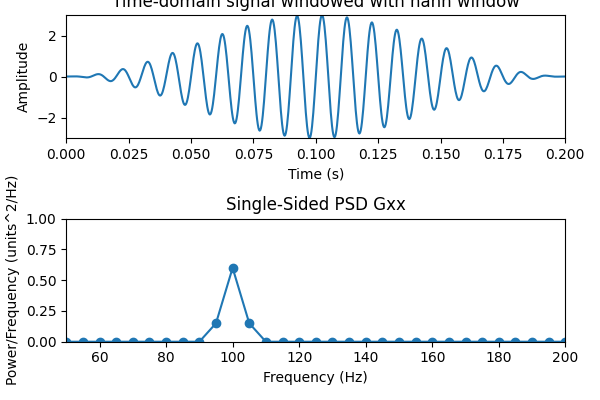

In [6]:
fs = 4000   # let's assume some sampling frequency in Hz
T = 0.2 # duration of the signal in seconds
t = np.arange(0, T, 1/fs) # time array
window_types = ['boxcar', 'hann', 'triang', 'blackman', 'hamming', 'flattop'] # more in scipy.signal.get_window

# This is a function to compute the PSD
def win_psd(x,fs, win='None', psdtype='Single'):

    """
    This computes the double sided (Sxx) or single sided (Gxx) power spectral density (PSD)
    from a windowed time-domain signal x. It includes a correction for a window.
    
    Arguments:
        x       - time domain signal
        fs      - sampling frequency
        win     - window applied to the signal (This is the window signal of the same length as x)
        psdtype - 'Single' for Gxx, 'Double' for Sxx
        
    Returns:
        freq  - vector with the frequencies
        PSD   - Either Gxx or Sxx
        
    """
    if len(x) % 2 != 0: x = x[:-1] # This ensures that x has an even number of samples
    N = len(x)
    dt = 1/fs
    T = N*dt
    t = np.arange(0, T, 1/fs)

    # Defaults window
    if win is 'None':
        win = signal.get_window('boxcar', N) # default to rectangular window if none provided

    x_win = x * win # apply window to the signal
    Aw = N/(np.sum(win**2)) # window correction factor

    X = np.fft.fft(x_win)*dt    # Linear Spectrum (need to multiply by dt)
    Sxx = (1/T)*(abs(X)**2) # Double-Sided PSD

    if psdtype == 'Double':
        PSD = Aw*Sxx # Double-Sided PSD with correction
        freq = np.fft.fftfreq(N, d=dt)
        
    elif psdtype =='Single':
        Gxx = Sxx[0:N//2 + 1].copy()
        Gxx[1:-1] = 2*Gxx[1:-1] # Single-Sided PSD
        PSD = Aw*Gxx # Single-Sided PSD with correction
        freq = np.fft.rfftfreq(N, d=dt)
        
    else:
        print("Let psd = 'Single' or psd ='Double' ")
    
    return PSD,freq, x_win, t # also return the windowed time-domain signal

fig, ax = plt.subplots(2,1, figsize=(6,4))
    
timeplot, = ax[0].plot([], [])
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Amplitude')
ax[0].set_xlim([0, T])
ax[0].set_ylim([-3,3])

psdplot, = ax[1].plot([], [],'-o')
#psdplot_max, = ax[1].plot([], [],'-x')
ax[1].set_title('Single-Sided PSD Gxx')
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Power/Frequency (units^2/Hz)')
ax[1].set_xlim([50,200])
ax[1].set_ylim([0, 1])


# Interactive plot to show the RMS computation with different sine waves
def interactive_psd(f1=100, win_type=1):
	
    fig.canvas.draw_idle()
    
    # Create sine wave
    x = 3*np.sin(2*np.pi*f1*t)
    win = signal.get_window(window_types[win_type], len(x)) # get the window
    df_eff = (np.sum(win**2)*fs)/((np.sum(win))**2) # effective noise bandwidth

    # Compute the single-sided PSD (this also does the windowing of the time-domain signal)
    Gxx, fG, x_win, time = win_psd(x, fs, win, 'Single')
    df = fG[1] - fG[0]  # equivalent to fs/N, but that was already computed in the function
    print(df)
    Gxx_max = np.max(Gxx) # maximum value of Gxx
    freq_Gxx_max = fG[np.argmax(Gxx)] # frequency at which max occurs

    # Update time-domain plot
    timeplot.set_data(time, x_win)
    ax[0].set_title('Time-domain signal windowed with ' + window_types[win_type]+' window')
    # Update PSD plot
    psdplot.set_data(fG, Gxx)
    
    # play audio
    #IPython.display.display(Audio(x.T, rate=fs, autoplay=False))
    
    # # Checking the energy equivalence
    # print("Checking the energy equivalence:")
    print("Mean-square of x[n], 1/N*sum(x[n]^2) =", np.mean(x**2))
    print("Gxx * df =", np.sum(Gxx)* df)
    # # RMS values
    # print("------------------------")
    # print("Computing the RMS values in time and freq domain:")
    print("RMS of x[n] using the time-domain signal, sqrt(1/N*sum(x[n]^2)) =", np.sqrt(np.mean(x**2)))
    print("RMS of x[n] using the PSD sqrt(Gxx_max*df) =", np.sqrt(Gxx_max*df_eff))
    
    
plt.tight_layout()
    
print("Adjust the frequency and amplitude of the sine wave using the sliders below")
interact(interactive_psd, f1=(50, 200, 0.1), win_type=(0, len(window_types)-1, 1))
